# Package installation and imports

In [ ]:
#%pip install --force-reinstall numpy
#%pip install --force-reinstall scipy==1.11.0 #run once, then uncomment, run again for new kernel
%pip install nltk
%pip install gensim
%pip install wordcloud
%pip install mplcursors
%pip install keras_tuner
%pip install tensorflow
%pip install re
%pip install num2words
%pip install mplcursors



---

---

In [ ]:
import numpy as np
import pandas as pd
import sqlite3
import re
from num2words import num2words
from nltk.stem import WordNetLemmatizer
import nltk
from gensim.parsing.preprocessing import remove_stopwords
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords, words
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import mplcursors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords, words, wordnet
from sklearn.utils import resample
from tensorflow.keras.layers import TextVectorization, Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample





# Ensure required NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')


---

True

# Data Loading

In [ ]:
# Load datafile
DB_FILE = '/content/nlp-data.db'

---

In [ ]:
# Load tweets data from SQLite database
con = sqlite3.connect(DB_FILE)
cur = con.cursor()
query = cur.execute("""
    SELECT Labels.NumericValue, RawTexts.Text
    FROM Documents
    INNER JOIN RawTexts ON Documents.RawTextID = RawTexts.RawTextID
    INNER JOIN Labels ON Documents.LabelID = Labels.LabelID
    WHERE Documents.Type="Review"
    ORDER BY RANDOM()
""")
reviews = pd.DataFrame(query.fetchall(), columns=['label', 'text'])

query = cur.execute("""
    SELECT Labels.NumericValue, RawTexts.Text
    FROM Documents
    INNER JOIN RawTexts ON Documents.RawTextID = RawTexts.RawTextID
    INNER JOIN Labels ON Documents.LabelID = Labels.LabelID
    WHERE Documents.Type="Tweet"
    ORDER BY RANDOM()
""")

tweets = pd.DataFrame(query.fetchall(), columns=['label', 'text'])

con.close()

# Pre-processing

In [ ]:
# Set of English words
english_words = set(words.words())

# Default stopwords
stop_words = set(stopwords.words('english'))

# Preserve negations and sentiment-bearing modal verbs
keep_words = {
    "don't", "aren't", "shouldn't", "mustn't", "wasn't", "couldn't",
    "won't", "can't", "isn't", "haven't", "wouldn't", "didn't",
    "hadn't", "weren't", "should", "must", "need", "might", "not"
}
filtered_stopwords = stop_words - keep_words

# Emoji and emoticon sentiment mapping
emoji_sentiment_map = {
    "😀": "happy", "😃": "joyful", "😄": "cheerful", "😁": "excited", "😆": "laughing",
    "😂": "hilarious", "🤣": "funny", "😊": "content", "😇": "blessed", "🙂": "positive",
    "🙃": "sarcastic", "😉": "playful", "😍": "love", "🥰": "affectionate", "😘": "flirty",
    "😗": "kiss", "😚": "adoring", "😋": "delicious", "😜": "silly", "😝": "mischievous",
    "😎": "cool", "🤩": "starstruck", "🥳": "celebratory", "😏": "smug", "😔": "disappointed",
    "😞": "sad", "😢": "tearful", "😭": "crying", "😤": "frustrated", "😡": "angry",
    "😠": "mad", "🤬": "furious", "😱": "shocked", "😨": "fearful", "😰": "anxious",
    "😥": "worried", "😓": "stressed", "🤯": "mind-blown", "😴": "sleepy", "🥱": "tired",
    "🤕": "injured", "🤢": "nauseous", "🤮": "disgusted", "🤗": "hugging", "🤔": "thoughtful",
    "🤨": "skeptical", "😐": "neutral", "😑": "expressionless", "😶": "speechless",
    "🙄": "eye-rolling", "😬": "awkward", "🤥": "lying", "🤦": "facepalm", "🤦‍♂️": "facepalm man",
    "🤦‍♀️": "facepalm woman", "😩": "sigh", "💔": "broken heart", "💘": "arrow heart",
    ":)": "happy", ":-)": "happy", ":D": "laughing", "XD": "hilarious",
    ":(": "sad", ":-(": "sad", ":'(": "crying", ">:(": "angry",
    ";)": "wink", ":-P": "playful", ":P": "playful", ":-O": "surprised",
    ":o": "shocked", ":-|": "neutral", ":|": "neutral"
}

# --- CLEANING FUNCTIONS ---

def to_lower(text):
    return text.lower() if isinstance(text, str) else text

def split_sticky_text(text):
    return re.sub(r'(?<=[a-zA-Z])(?=[A-Z0-9])', ' ', text)

def preserve_contractions(text):
    # Convert common negation contractions to "not" forms
    text = re.sub(r"\b(can|do|does|did|have|has|had|is|are|was|were|would|should|could|must|might|need|wo|ca|ai)n['’]t\b", r"\1 not", text)
    return text

def remove_symbols(text):
    return re.sub(r"[-._$*&,:;\"()+\\]", '', text)

def convert_numbers_to_words(text):
    return re.sub(r'\b\d+\b', lambda match: num2words(match.group()), text)

def remove_extra_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def convert_emojis_to_words(text):
    for emoticon, sentiment in emoji_sentiment_map.items():
        text = re.sub(re.escape(emoticon), sentiment, text, flags=re.IGNORECASE)
    return text

def remove_hashtags(text):
    return re.sub(r'#(\w+)', r'\1', text)

def remove_links(text):
    return re.sub(r'https?\s*:\s*//\s*\S+|www\s*\.\s*\S+', '', text)

def remove_ats(text):
    return re.sub(r'@\s*\w*\s*', '', text)

def remove_unicode(text):
    return re.sub(r'\\u[0-9A-Fa-f]{4}', '', text)

def reduce_repeated_characters(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

def remove_isolated_apostrophes(text):
    return re.sub(r"\s*'\s*", ' ', text)

def lemmatize_and_tokenize(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]

def clean_stopwords(tokens):
    return [word for word in tokens if word.lower() not in filtered_stopwords]

def remove_stray_apostrophe_tokens(tokens):
    return [t for t in tokens if t != "'"]

def normalize_quotes(text):
    # Replace curly quotes with straight quotes
    return text.replace('’', "'").replace('‘', "'").replace('“', '"').replace('”', '"')


# --- MAIN PREPROCESSING PIPELINE ---

def preprocess_dataframe(df):
    df['text'] = df['text'].astype(str).apply(to_lower)
    df['text'] = df['text'].apply(split_sticky_text)
    df['text'] = df['text'].apply(preserve_contractions)
    df['text'] = df['text'].apply(convert_emojis_to_words)
    df['text'] = df['text'].apply(remove_symbols)
    df['text'] = df['text'].apply(convert_numbers_to_words)
    df['text'] = df['text'].apply(remove_extra_whitespace)
    df['text'] = df['text'].apply(remove_hashtags)
    df['text'] = df['text'].apply(remove_links)
    df['text'] = df['text'].apply(remove_ats)
    df['text'] = df['text'].apply(remove_unicode)
    df['text'] = df['text'].apply(reduce_repeated_characters)
    df['text'] = df['text'].apply(remove_isolated_apostrophes)
    df['text'] = df['text'].apply(normalize_quotes)
    df['tokens'] = df['text'].apply(lemmatize_and_tokenize)
    df['tokens'] = df['tokens'].apply(remove_stray_apostrophe_tokens)
    # Uncomment if you want to remove stopwords
    # df['tokens'] = df['tokens'].apply(clean_stopwords)
    return df

# Example usage:
reviews = preprocess_dataframe(reviews)
tweets = preprocess_dataframe(tweets)
print(reviews[['text', 'tokens']].head())


                                                text  \
0  i bought this hoping it would be more like the...   
1  these guys will keep harassing you until you w...   
2  i could never get it to fit my eye correctly o...   
3  i had a larger one of these and wanted this sm...   
4  sturdy and festive goes great with my red and ...   

                                              tokens  
0  [i, bought, this, hop, it, would, be, more, li...  
1  [these, guy, will, keep, harass, you, until, y...  
2  [i, could, never, get, it, to, fit, my, eye, c...  
3  [i, have, a, large, one, of, these, and, want,...  
4  [sturdy, and, festive, go, great, with, my, re...  


# Visualization

Distribution of data

label
 0    22517
 1    19779
-1     7787
Name: count, dtype: int64
label
2    41000
1    41000
5    41000
3    41000
4    41000
Name: count, dtype: int64


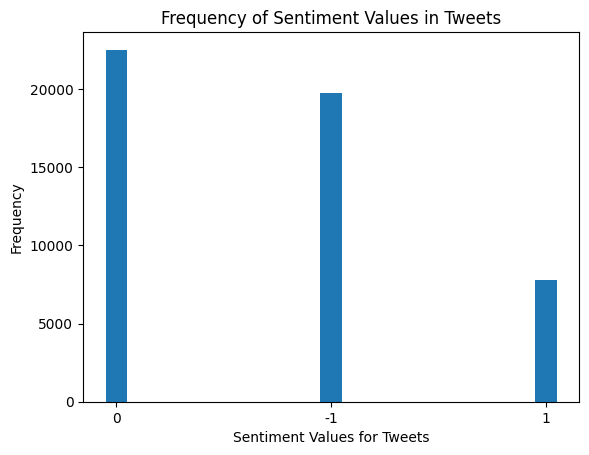

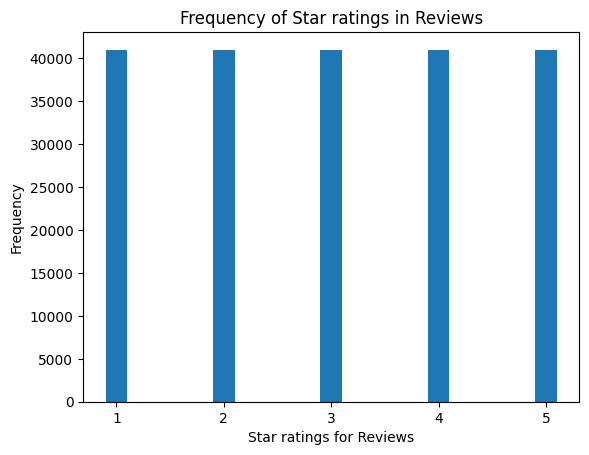

   label                                               text  \
0      2  i bought this hoping it would be more like the...   
1      1  these guys will keep harassing you until you w...   
2      2  i could never get it to fit my eye correctly o...   
3      5  i had a larger one of these and wanted this sm...   
4      5  sturdy and festive goes great with my red and ...   

                                              tokens  
0  [i, bought, this, hop, it, would, be, more, li...  
1  [these, guy, will, keep, harass, you, until, y...  
2  [i, could, never, get, it, to, fit, my, eye, c...  
3  [i, have, a, large, one, of, these, and, want,...  
4  [sturdy, and, festive, go, great, with, my, re...  
   label                                               text  \
0     -1  i bought this hoping it would be more like the...   
1     -1  these guys will keep harassing you until you w...   
2     -1  i could never get it to fit my eye correctly o...   
3      1  i had a larger one of these a

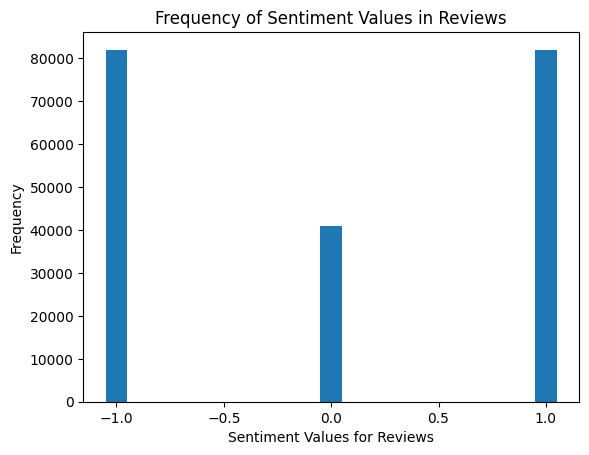

In [ ]:
print(tweets['label'].value_counts())
print(reviews['label'].value_counts())

plt.bar(np.array(["0", "-1", "1"]), tweets['label'].value_counts(), width = 0.1)
plt.xlabel("Sentiment Values for Tweets")
plt.ylabel("Frequency")
plt.title("Frequency of Sentiment Values in Tweets")
plt.show()

plt.bar(pd.unique(reviews['label']), reviews['label'].value_counts(), width = 0.2)
plt.xlabel("Star ratings for Reviews")
plt.ylabel("Frequency")
plt.title("Frequency of Star ratings in Reviews")

plt.show()

def convert_stars_to_ternary(label):
    if label == 1 or label ==2:
        return -1
    elif label == 3:
        return 0
    elif label == 4 or label == 5:
        return 1

print(reviews.head())
reviews['label'] = reviews['label'].apply(convert_stars_to_ternary)

print(reviews.head())
# Plot ternary sentiment values for reviews
converted_counts = reviews['label'].value_counts().sort_index()
plt.bar(converted_counts.index, converted_counts.values, width=0.1)
plt.xlabel("Sentiment Values for Reviews")
plt.ylabel("Frequency")
plt.title("Frequency of Sentiment Values in Reviews")
plt.show()

Unigram, bigram, frequency

/tmp/ipython-input-59-4046116441.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


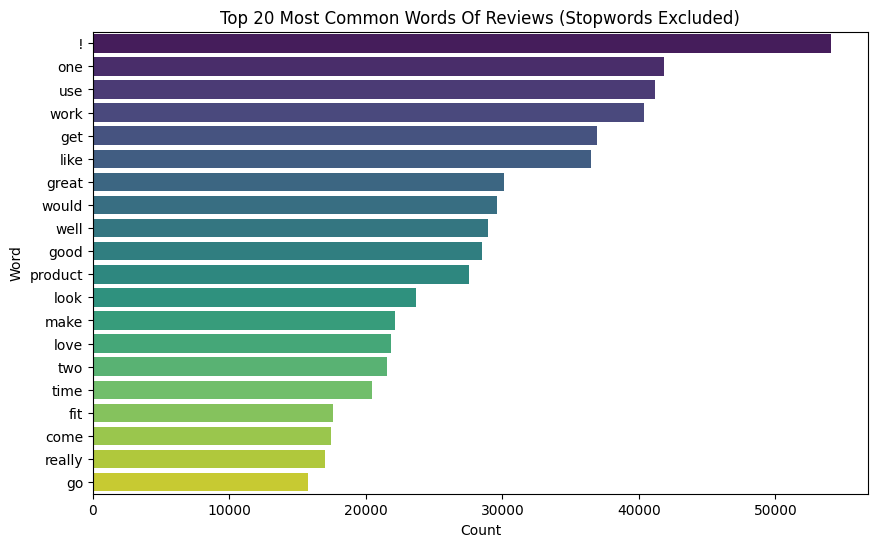

/tmp/ipython-input-59-4046116441.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


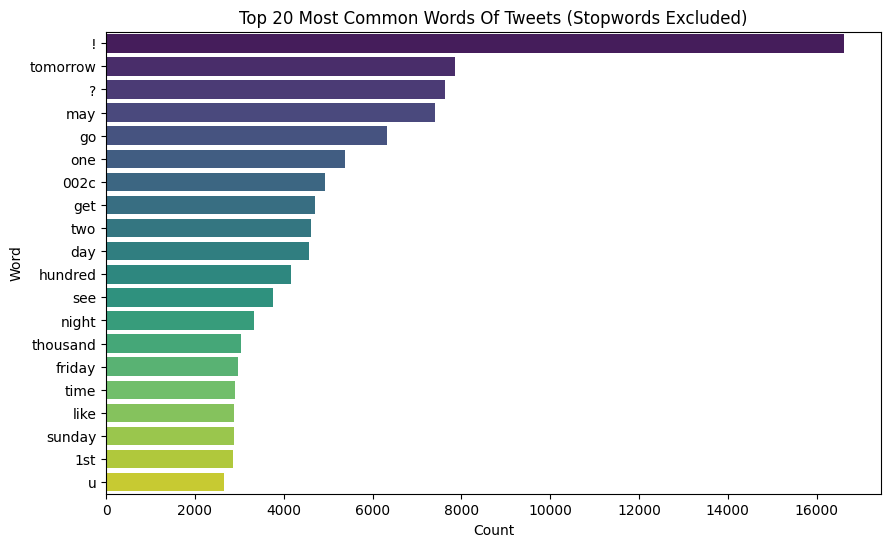

/tmp/ipython-input-59-4046116441.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=[" ".join(bigram) for bigram in bigrams], palette="magma")


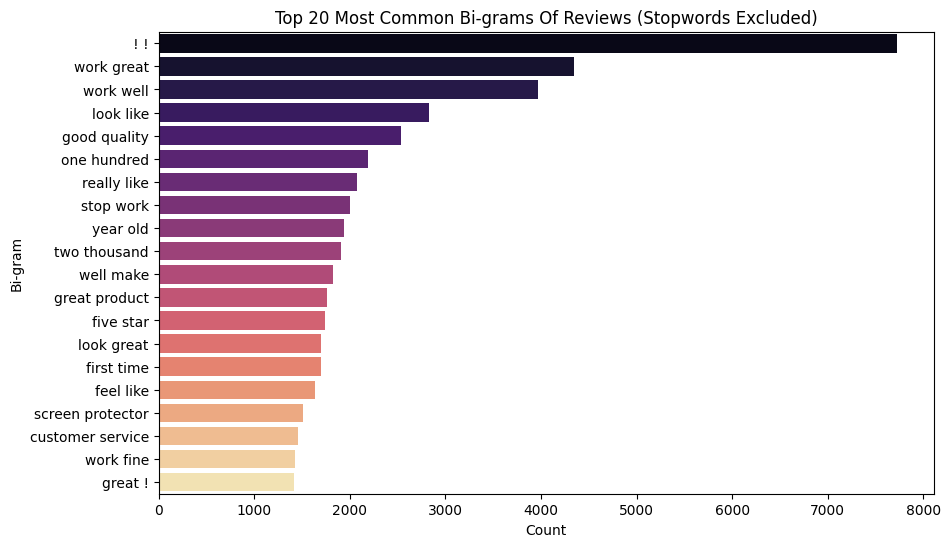

/tmp/ipython-input-59-4046116441.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=[" ".join(bigram) for bigram in bigrams], palette="magma")


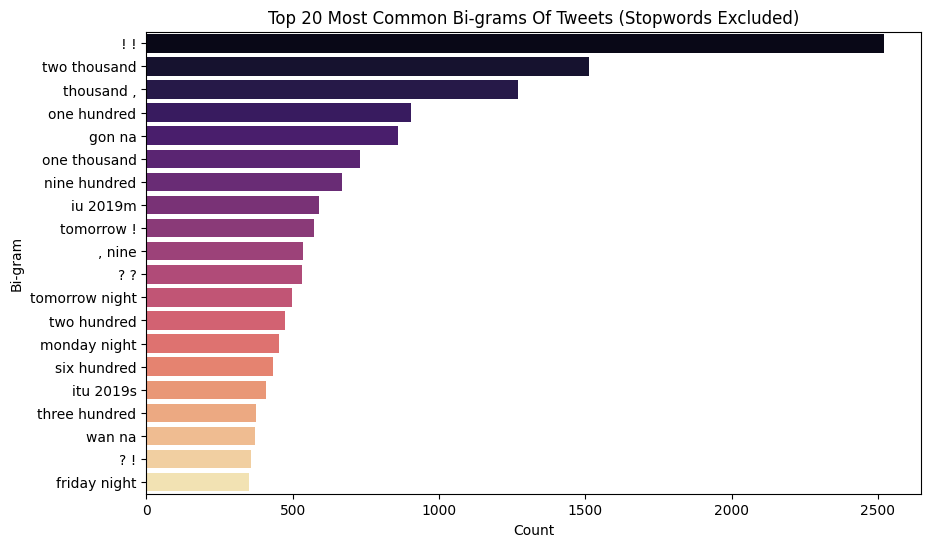

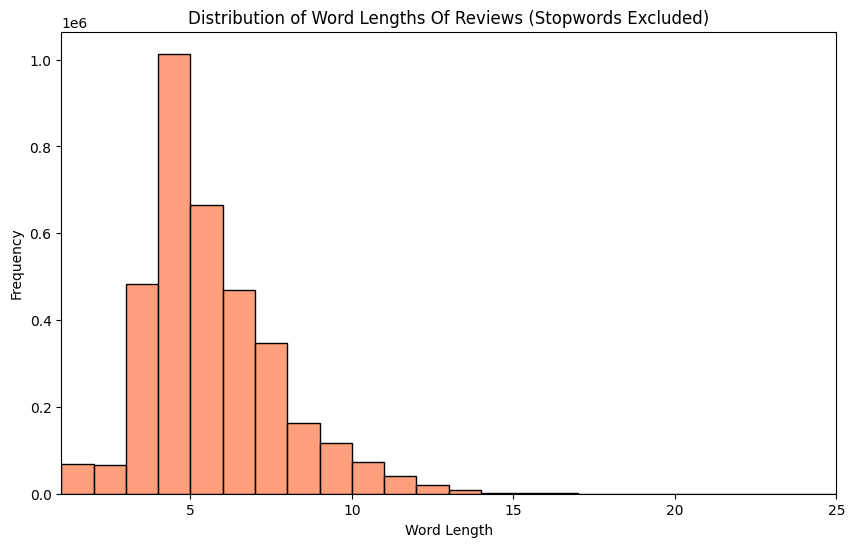

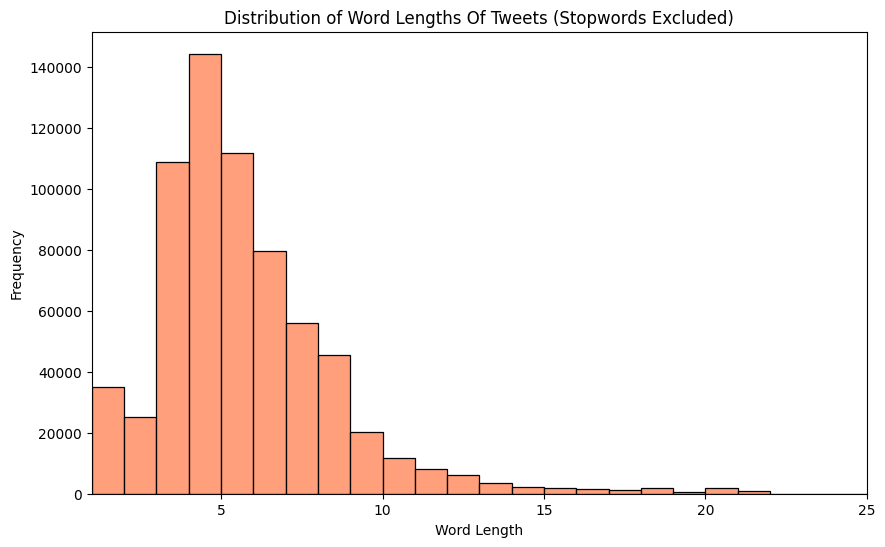

Statistics for Reviews:
Mean token length: 5.15
Median token length: 5.0
Max token length: 42
Min token length: 1

Statistics for Tweets:
Mean token length: 5.24
Median token length: 5.0
Max token length: 56
Min token length: 1



In [ ]:


# Define a function to generate bi-grams
def get_bigrams(tokens):
    return list(ngrams(tokens, 2))

# Apply bi-gram extraction
reviews['bigrams'] = reviews['tokens'].apply(get_bigrams)
tweets['bigrams'] = tweets['tokens'].apply(get_bigrams)

# --- Unigram Frequency Analysis (Filtering out stopwords) ---

# Flatten tokenized data and remove stopwords
all_tokens_r = [token.lower() for tokens in reviews['tokens'] for token in tokens if token.lower() not in stop_words]
all_tokens_t = [token.lower() for tokens in tweets['tokens'] for token in tokens if token.lower() not in stop_words]

# Compute frequency distribution of unigrams
freq_counter_r = Counter(all_tokens_r)
freq_counter_t = Counter(all_tokens_t)

# --- Bigram Frequency Analysis (Optional stopword filtering) ---

# Helper function to check if both words in a bigram are not stopwords
def is_informative_bigram(bigram):
    return all(word.lower() not in stop_words for word in bigram)

# Filter and flatten bigrams
all_bigrams_r = [bigram for bigrams in reviews['bigrams'] for bigram in bigrams if is_informative_bigram(bigram)]
all_bigrams_t = [bigram for bigrams in tweets['bigrams'] for bigram in bigrams if is_informative_bigram(bigram)]

# Compute frequency distribution of bigrams (optional)
freq_bigrams_r = Counter(all_bigrams_r)
freq_bigrams_t = Counter(all_bigrams_t)

# Compute frequency distribution of bi-grams
freq_counter_bigrams_r = Counter(all_bigrams_r)
freq_counter_bigrams_t = Counter(all_bigrams_t)

# --- Plot 1: Top 20 Most Frequent Unigrams ---
def plot_common_words(freq_counter, title):
    most_common = freq_counter.most_common(20)
    words, counts = zip(*most_common)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), palette="viridis")
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel("Word")
    plt.show()

plot_common_words(freq_counter_r, "Top 20 Most Common Words Of Reviews (Stopwords Excluded)")
plot_common_words(freq_counter_t, "Top 20 Most Common Words Of Tweets (Stopwords Excluded)")

# --- Plot 2: Top 20 Most Frequent Bi-grams ---
def plot_common_bigrams(freq_counter, title):
    most_common = freq_counter.most_common(20)
    bigrams, counts = zip(*most_common)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=[" ".join(bigram) for bigram in bigrams], palette="magma")
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel("Bi-gram")
    plt.show()

plot_common_bigrams(freq_counter_bigrams_r, "Top 20 Most Common Bi-grams Of Reviews (Stopwords Excluded)")
plot_common_bigrams(freq_counter_bigrams_t, "Top 20 Most Common Bi-grams Of Tweets (Stopwords Excluded)")

# --- Plot 3: Distribution of Word Lengths ---
def plot_word_lengths(all_tokens, title):
    word_lengths = [len(word) for word in all_tokens]
    plt.figure(figsize=(10, 6))
    sns.histplot(word_lengths, bins=range(1, max(word_lengths) + 2), kde=False, color='coral')
    plt.title(title)
    plt.xlabel("Word Length")
    plt.ylabel("Frequency")
    plt.xlim(1, 25)

    plt.show()


plot_word_lengths(all_tokens_r, "Distribution of Word Lengths Of Reviews (Stopwords Excluded)")
plot_word_lengths(all_tokens_t, "Distribution of Word Lengths Of Tweets (Stopwords Excluded)")

def token_length_stats(tokens, dataset_name):
    lengths = [len(token) for token in tokens]
    mean_len = np.mean(lengths)
    median_len = np.median(lengths)
    max_len = np.max(lengths)
    min_len = np.min(lengths)
    print(f"Statistics for {dataset_name}:")
    print(f"Mean token length: {mean_len:.2f}")
    print(f"Median token length: {median_len}")
    print(f"Max token length: {max_len}")
    print(f"Min token length: {min_len}")
    print()

token_length_stats(all_tokens_r, "Reviews")
token_length_stats(all_tokens_t, "Tweets")

Frequency reviews plotted against tweets

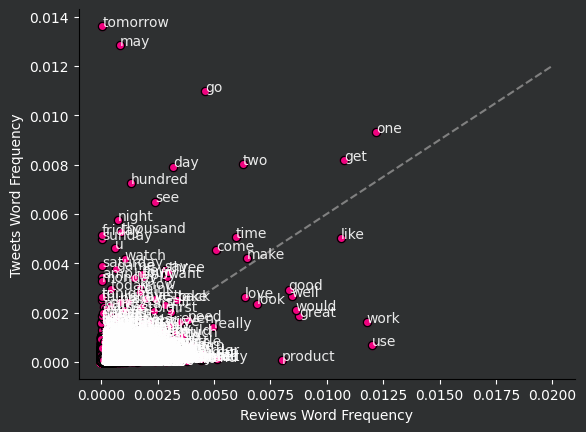

In [ ]:
# --- Plot 5: Word Scatter Comparing Reviews and Tweets (Filtering out stopwords) ---
def plot_word_scatter(reviews_df, tweets_df):
    """
    Creates a scatter plot comparing word frequencies in 'reviews' and 'tweets' DataFrames,
    highlighting outliers (words far from the main cluster). Stopwords are excluded.
    """
    # Flatten tokens, convert to lowercase, filter alphabetic words and remove stopwords
    reviews_tokens = [
        token.lower()
        for tokens in reviews_df['tokens']
        for token in tokens
        if token.isalpha() and token.lower() not in stop_words
    ]
    tweets_tokens = [
        token.lower()
        for tokens in tweets_df['tokens']
        for token in tokens
        if token.isalpha() and token.lower() not in stop_words
    ]

    # Compute word frequency distributions
    reviews_freq = Counter(reviews_tokens)
    tweets_freq = Counter(tweets_tokens)

    # Collect unique words
    all_words = set(reviews_freq.keys()).union(set(tweets_freq.keys()))

    # Compute frequency proportions
    total_reviews = sum(reviews_freq.values())
    total_tweets = sum(tweets_freq.values())
    word_data = []
    for word in all_words:
        proportion_reviews = reviews_freq[word] / total_reviews
        proportion_tweets = tweets_freq[word] / total_tweets
        word_data.append((word, proportion_reviews, proportion_tweets))

    word_df = pd.DataFrame(word_data, columns=['word', 'proportion_reviews', 'proportion_tweets'])

    # Compute the centroid (mean point)
    mean_x = word_df['proportion_reviews'].mean()
    mean_y = word_df['proportion_tweets'].mean()

    # Compute Euclidean distances of each point from the centroid
    word_df['distance'] = np.sqrt((word_df['proportion_reviews'] - mean_x)**2 +
                                  (word_df['proportion_tweets'] - mean_y)**2)

    # Define outlier threshold (e.g., top 5% furthest points)
    threshold = word_df['distance'].quantile(0.95)
    outliers = word_df[word_df['distance'] > threshold]

    # Plotting
    fig, ax = plt.subplots()
    ax.scatter(word_df["proportion_reviews"], word_df["proportion_tweets"], color="#f0027f", alpha=0.5)

    # Highlight outliers
    ax.scatter(outliers["proportion_reviews"], outliers["proportion_tweets"],
               color="#f0027f", edgecolors="black", zorder=3)

    # Annotate outliers
    for _, row in outliers.iterrows():
        ax.annotate(row["word"], (row["proportion_reviews"], row["proportion_tweets"]), color="white", alpha=0.9)

    # Customize plot appearance
    ax.grid(False)
    ax.set_xlabel("Reviews Word Frequency")
    ax.set_ylabel("Tweets Word Frequency")
    ax.plot([0, 0.02], [0, 0.012], color="gray", linestyle="--")
    fig.patch.set_facecolor("#2E3031")
    ax.set_facecolor("#2E3031")
    ax.xaxis.label.set_color("white")
    ax.yaxis.label.set_color("white")
    ax.tick_params(axis="x", colors="white")
    ax.tick_params(axis="y", colors="white")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.show()

# Example Usage:
plot_word_scatter(reviews, tweets)

# Data split

Shift labels for NN

In [ ]:
tweets['source'] = 'twitter'
reviews['source'] = 'amazon'
data = pd.concat([reviews, tweets], ignore_index=True)
print(data.head())
print("Unique labels:", data['label'].unique())

# --- 2. Encode labels ---
label_map = {-1: 0, 0: 1, 1: 2}
data['label'] = data['label'].map(label_map)


   label                                               text  \
0     -1  i bought this hoping it would be more like the...   
1     -1  these guys will keep harassing you until you w...   
2     -1  i could never get it to fit my eye correctly o...   
3      1  i had a larger one of these and wanted this sm...   
4      1  sturdy and festive goes great with my red and ...   

                                              tokens  \
0  [i, bought, this, hop, it, would, be, more, li...   
1  [these, guy, will, keep, harass, you, until, y...   
2  [i, could, never, get, it, to, fit, my, eye, c...   
3  [i, have, a, large, one, of, these, and, want,...   
4  [sturdy, and, festive, go, great, with, my, re...   

                                             bigrams  source  
0  [(i, bought), (bought, this), (this, hop), (ho...  amazon  
1  [(these, guy), (guy, will), (will, keep), (kee...  amazon  
2  [(i, could), (could, never), (never, get), (ge...  amazon  
3  [(i, have), (have, a), (a, la

In [ ]:
def get_splits(data, model_type, random_state=42):
    """
    Returns train, val, test splits based on model type.

    Args:
        data: full dataframe with 'label' and 'source' columns.
        model_type: one of ['cnn_lstm', 'lr', 'dann']
        random_state: random seed

    Returns:
        For 'cnn_lstm' and 'dann': (train_df, val_df, test_df)
        For 'lr': (train_val_df, None, test_df)
    """

    if model_type in ['cnn_lstm']:
        # 70/15/15 split
        train_val, test = train_test_split(
            data, test_size=0.15, stratify=data['label'], random_state=random_state
        )
        train, val = train_test_split(
            train_val, test_size=0.1765, stratify=train_val['label'], random_state=random_state
        )
        return train, val, test

    elif model_type == 'lr':
        # 85/15 split (no val)
        train_val, test = train_test_split(
            data, test_size=0.15, stratify=data['label'], random_state=random_state
        )
        return train_val, None, test

    elif model_type == 'dann':
        # 85/15 split first
        train_val, test = train_test_split(
            data, test_size=0.15, stratify=data['label'], random_state=random_state
        )
        # Undersample reviews in train_val to balance domains
        train_val_reviews = train_val[train_val['source'] == 'amazon']
        train_val_tweets = train_val[train_val['source'] == 'twitter']

        train_val_reviews_under = resample(
            train_val_reviews,
            replace=False,
            n_samples=len(train_val_tweets),
            random_state=random_state
        )

        train_val_balanced = pd.concat([train_val_reviews_under, train_val_tweets], ignore_index=True)
        # Map domains to ids for DANN
        domain_map = {'twitter': 0, 'amazon': 1}
        train_val_balanced['domain_id'] = train_val_balanced['source'].map(domain_map)

        # --- 3. Train/Val/Test Split (70/15/15) ---

        train_val_dann, test_dann = train_test_split(
            train_val_balanced, test_size=0.15, stratify=train_val_balanced['label'], random_state=42
        )
        train_dann, val_dann = train_test_split(
            train_val_dann, test_size=0.1765, stratify=train_val_dann['label'], random_state=42
        )


        return train_dann, val_dann, test_dann

    else:
        raise ValueError(f"Unknown model_type '{model_type}'. Choose from ['cnn_lstm', 'lr', 'dann'].")

train_cnn, val_cnn, test_cnn = get_splits(data, model_type='cnn_lstm', random_state=42)
train_lstm, val_lstm, test_lstm = get_splits(data, model_type='cnn_lstm', random_state=42)
train_val_lr, _, test_lr = get_splits(data, model_type='lr', random_state=42)
train_dann, val_dann, test_dann = get_splits(data, model_type='dann', random_state=42)

# Encoding

TF-IDF (For LR)

In [ ]:

# Prepare text for TF-IDF
X_train_text = train_val_lr['tokens'].apply(lambda toks: " ".join(toks))
X_test_text = test_lr['tokens'].apply(lambda toks: " ".join(toks))

y_train_lr = train_val_lr['label']
y_test_lr = test_lr['label']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=29000,
    min_df=5,
    max_df=0.8,
    norm='l2'
)

# Fit vectorizer on train+val text and transform
X_train_val_tfidf = vectorizer.fit_transform(X_train_text)

# Transform test text
X_test_tfidf = vectorizer.transform(X_test_text)

Word Embeddings (For CNN, LSTM)

In [ ]:
#CNN
# --- 1. Parameters ---
max_tokens_cnn     = 20000
max_len_cnn        = 100

x_train_txt_cnn = train_cnn['tokens'].apply(lambda toks: " ".join(toks)).values
x_val_txt_cnn   = val_cnn['tokens'].apply(lambda toks: " ".join(toks)).values
x_test_txt_cnn  = test_cnn['tokens'].apply(lambda toks: " ".join(toks)).values

y_train_cnn = to_categorical(train_cnn['label'].values, num_classes=3)
y_val_cnn   = to_categorical(val_cnn['label'].values, num_classes=3)
y_test_cnn  = to_categorical(test_cnn['label'].values, num_classes=3)


# --- 4. Vectorization ---
vectorize = TextVectorization(
    max_tokens=max_tokens_cnn,
    standardize=None,
    split='whitespace',
    output_mode='int',
    output_sequence_length=max_len_cnn
)
vectorize.adapt(np.concatenate([x_train_txt_cnn, x_val_txt_cnn]))

x_train_cnn = vectorize(x_train_txt_cnn).numpy()
x_val_cnn   = vectorize(x_val_txt_cnn).numpy()
x_test_cnn  = vectorize(x_test_txt_cnn).numpy()

In [ ]:
#LSTM:


# === Assume reviews and tweets DataFrames are already loaded ===
# and have columns: 'label' (values in {0, 1, 2}), 'tokens' (list of tokens)
# --- 3. Train/Val/Test Split (70/15/15) for LSTM ---


train_X_lstm, train_Y_lstm = train_lstm['tokens'].reset_index(drop=True), train_lstm['label'].reset_index(drop=True)
val_X_lstm, val_Y_lstm     = val_lstm['tokens'].reset_index(drop=True), val_lstm['label'].reset_index(drop=True)
test_X_lstm, test_Y_lstm   = test_lstm['tokens'].reset_index(drop=True), test_lstm['label'].reset_index(drop=True)



print(f"Train samples: {len(train_X_lstm)}, Validation samples: {len(val_X_lstm)}, Test samples: {len(test_X_lstm)}")

# Tokenizer on all text
all_texts = [' '.join(tokens) for tokens in train_X_lstm.tolist() + val_X_lstm.tolist() + test_X_lstm.tolist()]
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(all_texts)

# Convert to sequences
train_seqs = tokenizer.texts_to_sequences(train_X_lstm.apply(lambda x: ' '.join(x)))
val_seqs   = tokenizer.texts_to_sequences(val_X_lstm.apply(lambda x: ' '.join(x)))
test_seqs  = tokenizer.texts_to_sequences(test_X_lstm.apply(lambda x: ' '.join(x)))

# Padding
max_len = 75
X_train_seq_lstm = pad_sequences(train_seqs, maxlen=max_len, padding='post', truncating='post')
X_val_seq_lstm   = pad_sequences(val_seqs, maxlen=max_len, padding='post', truncating='post')
X_test_seq_lstm  = pad_sequences(test_seqs, maxlen=max_len, padding='post', truncating='post')

# Word2Vec on train only
w2v_dim = 50
w2v_model = Word2Vec(
    sentences=train_X_lstm.tolist(),
    vector_size=w2v_dim,
    window=5,
    min_count=3,
    sg=0,
    workers=8,
    epochs=3
)

# Build embedding matrix
vocab_size = min(len(tokenizer.word_index) + 1, 20000)
embedding_matrix = np.zeros((vocab_size, w2v_dim))

missing_tokens = 0
for word, idx in tokenizer.word_index.items():
    if idx >= vocab_size:
        continue
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]
    else:
        missing_tokens += 1
print(f"Number of tokens not found in Word2Vec embeddings: {missing_tokens}")


y_train_cat_lstm = to_categorical(train_Y_lstm)
y_val_cat_lstm   = to_categorical(val_Y_lstm)
y_test_cat_lstm  = to_categorical(test_Y_lstm)


Train samples: 178551, Validation samples: 38269, Test samples: 38263
Number of tokens not found in Word2Vec embeddings: 895


# CNN

Main model

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5580/5580 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6650 - loss: 0.7433 - val_accuracy: 0.7152 - val_loss: 0.6552
Epoch 2/5
5580/5580 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7589 - loss: 0.5672 - val_accuracy: 0.7227 - val_loss: 0.6445
Epoch 3/5
5580/5580 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8133 - loss: 0.4494 - val_accuracy: 0.7109 - val_loss: 0.6949
Epoch 4/5
5580/5580 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8680 - loss: 0.3289 - val_accuracy: 0.7066 - val_loss: 0.8570
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Classification Report:
              precision    recall  f1-score   support

    negative      0.740     0.802     0.770     13468
     neutral      0.555     0.426     0.482      9528
    positive      0.780     0.836     0.807     15267

    accuracy                          0.722     38263
   macro avg      0.692     0.688     0.686     38263
weighted avg      0.710     0.722     0.713     38263



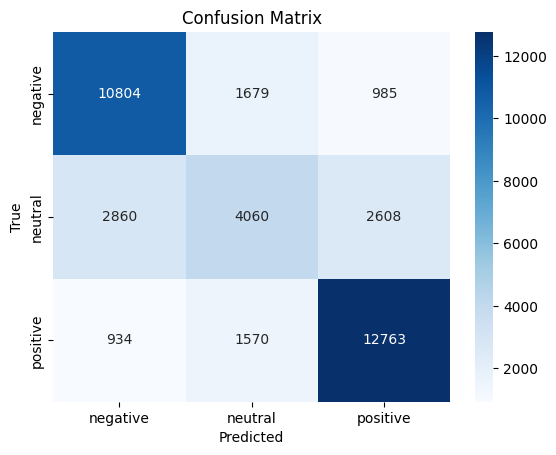

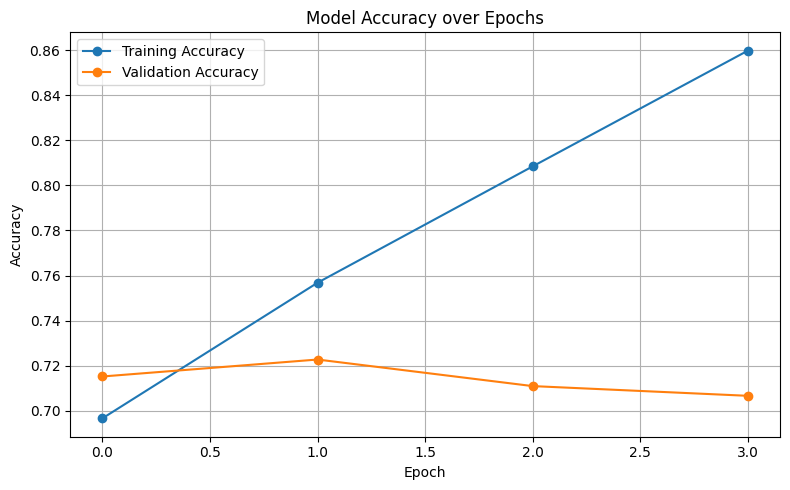


Prediction: positive
Probabilities: [0.14620137 0.2409379  0.6128607 ]


In [ ]:
#Main

# --- 1. Parameters ---
embedding_dims = 100
no_of_filters  = 400
kernel_size    = 5
hidden_dims    = 150
batch_size     = 32
epochs         = 5

# --- 5. Model ---
cnn_model = Sequential([
    Embedding(input_dim=max_tokens_cnn, output_dim=embedding_dims, input_length=max_len),
    Conv1D(no_of_filters, kernel_size, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(hidden_dims, activation='relu'),
    Dense(3, activation='softmax')
])

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# --- 6. Train ---
early_stop = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

cnn_history = cnn_model.fit(
    x_train_cnn, y_train_cnn,
    validation_data=(x_val_cnn, y_val_cnn),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stop]
)

# --- 7. Evaluate ---
y_pred_probs_cnn = cnn_model.predict(x_test_cnn)
y_pred_cnn = np.argmax(y_pred_probs_cnn, axis=1)
y_true_cnn = np.argmax(y_test_cnn, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=["negative", "neutral", "positive"], digits = 3))

cm = confusion_matrix(y_true_cnn, y_pred_cnn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(8, 5))
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 8. Predict Single Sentence ---
def predict_sentiment(text):
    text = " ".join(text.lower().split())
    vec = vectorize([text])
    prob = cnn_model.predict(vec, verbose=0)[0]
    label = np.argmax(prob)
    label_map = {0: "negative", 1: "neutral", 2: "positive"}
    return label_map[label], prob

# Example
label, prob = predict_sentiment("I absolutely loved the service and the quality!")
print("\nPrediction:", label)
print("Probabilities:", prob)



Other considered models

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 100, 100)  │  2,000,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 96, 400)   │    200,400 │ embedding_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 400)       │          0 │ conv1d_6[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gradient_reversal_… │ (None, 400)       │          0 │ global_max_pooli… │
│ (GradientReversalL… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 150)       │     60,150 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 32)        │     12,832 │ gradient_reversa… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentiment (Dense)   │ (None, 3)         │        453 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ domain (Dense)      │ (None, 2)         │         66 │ dense_17[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,273,901 (8.67 MB)

 Trainable params: 2,273,901 (8.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1856/1856 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - domain_accuracy: 0.5291 - domain_loss: 0.7870 - loss: 1.7575 - sentiment_accuracy: 0.5225 - sentiment_loss: 0.9705 - val_domain_accuracy: 0.6351 - val_domain_loss: 0.6934 - val_loss: 1.4808 - val_sentiment_accuracy: 0.6366 - val_sentiment_loss: 0.7874
Epoch 2/15
1856/1856 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - domain_accuracy: 0.5962 - domain_loss: 0.6670 - loss: 1.3800 - sentiment_accuracy: 0.6867 - sentiment_loss: 0.7130 - val_domain_accuracy: 0.5171 - val_domain_loss: 0.6901 - val_loss: 1.4537 - val_sentiment_accuracy: 0.6590 - val_sentiment_loss: 0.7635
Epoch 3/15
1856/1856 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - domain_accuracy: 0.5444 - domain_loss: 0.6848 - loss: 1.2734 - sentiment_accuracy: 0.7539 - sentiment_loss: 0.5886 - val_domain_accuracy: 0.4996 - val_domain_loss: 0.6927 - val_loss: 1.4558 - val_sentiment_accuracy: 0.6703 - val_sentiment_loss: 0.7631
Epoch 4/15
1856/1856 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - domain_accuracy: 0.

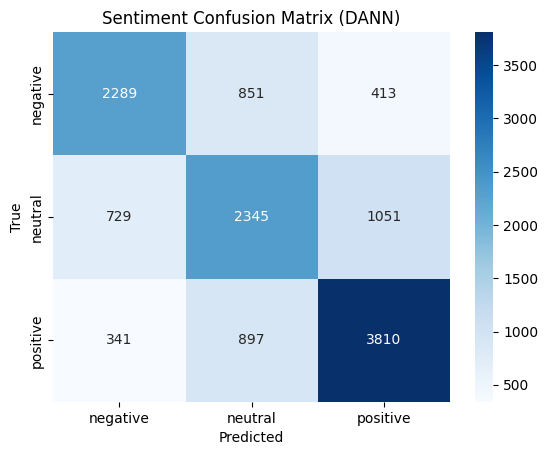

398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

--- DOMAIN CLASSIFICATION PERFORMANCE ---
              precision    recall  f1-score   support

     twitter       0.51      1.00      0.68      6483
      amazon       0.81      0.01      0.02      6243

    accuracy                           0.51     12726
   macro avg       0.66      0.50      0.35     12726
weighted avg       0.66      0.51      0.35     12726



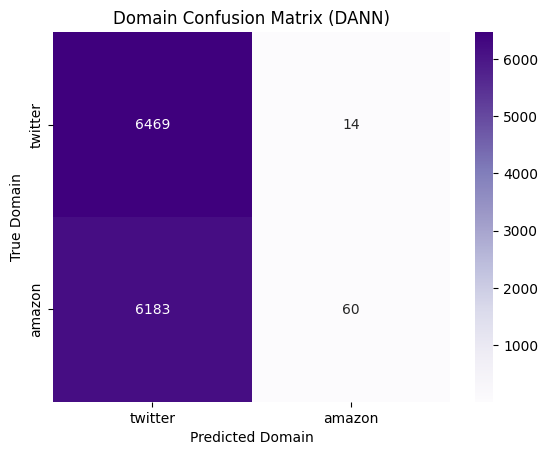

In [ ]:
"""
Domain-Adversarial Neural Network (DANN) to classify sentiment and domain (source).
"""

# --- 1. Gradient Reversal Layer ---
class GradientReversalLayer(Layer):
    def __init__(self, hp_lambda=1.0, **kwargs):
        super().__init__(**kwargs)
        self.hp_lambda = hp_lambda
    def call(self, x):
        @tf.custom_gradient
        def _reverse_grad(x):
            def grad(dy): return -self.hp_lambda * dy
            return x, grad
        return _reverse_grad(x)


# --- 2. Extract X and Y ---
train_X_dann = train_dann['tokens'].reset_index(drop=True)
val_X_dann   = val_dann['tokens'].reset_index(drop=True)
test_X_dann  = test_dann['tokens'].reset_index(drop=True)

train_Y_dann = train_dann['label'].reset_index(drop=True)
val_Y_dann   = val_dann['label'].reset_index(drop=True)
test_Y_dann  = test_dann['label'].reset_index(drop=True)

# --- 3. Convert tokens to strings ---
for df in [train_dann, val_dann, test_dann]:
    df['txt'] = df['tokens'].apply(lambda toks: " ".join(toks))

# --- 4. Text Vectorization ---
max_tokens = 20000
max_len = 100

vectorizer = TextVectorization(
    max_tokens=max_tokens,
    standardize=None,
    split='whitespace',
    output_mode='int',
    output_sequence_length=max_len
)
vectorizer.adapt(np.concatenate([train_dann['txt'].values, val_dann['txt'].values]))

x_train_dann = vectorizer(train_dann['txt'])
x_val_dann   = vectorizer(val_dann['txt'])
x_test_dann  = vectorizer(test_dann['txt'])

# --- 5. Prepare Targets ---
y_train_sent_dann = to_categorical(train_dann['label'].values, num_classes=3)
y_val_sent_dann   = to_categorical(val_dann['label'].values, num_classes=3)
y_test_sent_dann  = to_categorical(test_dann['label'].values, num_classes=3)

y_train_dom_dann = to_categorical(train_dann['domain_id'].values, num_classes=2)
y_val_dom_dann   = to_categorical(val_dann['domain_id'].values, num_classes=2)
y_test_dom_dann  = to_categorical(test_dann['domain_id'].values, num_classes=2)

# --- 6. Build DANN Model ---
embedding_dims = 100
no_of_filters = 400
kernel_size = 5
hidden_dims = 150

text_input = Input(shape=(max_len,), name='text_input')
x = Embedding(max_tokens, embedding_dims, input_length=max_len)(text_input)
x = Conv1D(no_of_filters, kernel_size, activation='relu')(x)
shared_feat = GlobalMaxPooling1D()(x)

# Sentiment branch
sent_output = Dense(hidden_dims, activation='relu')(shared_feat)
sent_output = Dense(3, activation='softmax', name='sentiment')(sent_output)

# Domain branch with GRL
grl = GradientReversalLayer(hp_lambda=1.0)(shared_feat)
dom_output = Dense(32, activation='relu')(grl)
dom_output = Dense(2, activation='softmax', name='domain')(dom_output)

model_dann = Model(inputs=text_input, outputs=[sent_output, dom_output])
model_dann.compile(
    optimizer='adam',
    loss={'sentiment': 'categorical_crossentropy', 'domain': 'categorical_crossentropy'},
    loss_weights={'sentiment': 1.0, 'domain': 1.0},
    metrics={'sentiment': 'accuracy', 'domain': 'accuracy'}
)
model_dann.summary()

# --- 7. Train Model ---
early_stop = EarlyStopping(monitor='val_sentiment_accuracy', mode='max', patience=2, restore_best_weights=True)

history_dann = model_dann.fit(
    x_train_dann,
    {'sentiment': y_train_sent_dann, 'domain': y_train_dom_dann},
    validation_data=(x_val_dann, {'sentiment': y_val_sent_dann, 'domain': y_val_dom_dann}),
    batch_size=32,
    epochs=15,
    callbacks=[early_stop]
)

# --- 8. Evaluate Sentiment by Domain ---
y_pred_sent_dann, _ = model_dann.predict(x_test_dann)
y_pred_lbl_dann = np.argmax(y_pred_sent_dann, axis=1)
y_true_lbl_dann = np.argmax(y_test_sent_dann, axis=1)

for src in ['twitter', 'amazon']:
    idx = test_dann['source'] == src
    print(f"\n--- {src.upper()} Performance ---")
    print(classification_report(
        y_true_lbl_dann[idx], y_pred_lbl_dann[idx],
        target_names=['negative', 'neutral', 'positive']
    ))

# --- 9. Sentiment Confusion Matrix ---
cm_sent_dann = confusion_matrix(y_true_lbl_dann, y_pred_lbl_dann)
sns.heatmap(cm_sent_dann, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Sentiment Confusion Matrix (DANN)")
plt.show()

# --- 10. Domain Prediction Evaluation ---
_, y_pred_dom_dann = model_dann.predict(x_test_dann)
y_pred_dom_lbl_dann = np.argmax(y_pred_dom_dann, axis=1)
y_true_dom_lbl_dann = np.argmax(y_test_dom_dann, axis=1)

print("\n--- DOMAIN CLASSIFICATION PERFORMANCE ---")
print(classification_report(
    y_true_dom_lbl_dann, y_pred_dom_lbl_dann,
    target_names=['twitter', 'amazon']
))

# --- 11. Domain Confusion Matrix ---
cm_dom_dann = confusion_matrix(y_true_dom_lbl_dann, y_pred_dom_lbl_dann)
sns.heatmap(cm_dom_dann, annot=True, fmt='d', cmap='Purples',
            xticklabels=['twitter', 'amazon'],
            yticklabels=['twitter', 'amazon'])
plt.xlabel("Predicted Domain")
plt.ylabel("True Domain")
plt.title("Domain Confusion Matrix (DANN)")
plt.show()


In [ ]:
#Code used for tuning hyper-parameters
"""
import keras_tuner as kt


# --- 1. Parameters ---
max_tokens = 20000
max_len = 100

# --- 2. Data Preparation ---
label_map = {-1: 0, 0: 1, 1: 2}
data['label'] = data['label'].map(label_map)

train, test = train_test_split(data, test_size=0.3, random_state=42, stratify=data['label'])
x_train_txt = train['tokens'].apply(lambda toks: " ".join(toks)).values
x_test_txt  = test['tokens'].apply(lambda toks: " ".join(toks)).values
y_train     = to_categorical(train['label'].values, num_classes=3)
y_test      = to_categorical(test['label'].values, num_classes=3)

vectorize = TextVectorization(max_tokens=max_tokens, output_sequence_length=max_len)
vectorize.adapt(x_train_txt)
x_train = vectorize(x_train_txt).numpy()
x_test  = vectorize(x_test_txt).numpy()

# --- 3. Define Model for Tuning ---
def build_model(hp):
    model = Sequential([
        Embedding(input_dim=max_tokens, output_dim=hp.Int('embedding_dims', 50, 200, step=50), input_length=max_len),
        Conv1D(filters=hp.Int('no_of_filters', 100, 400, step=50),
               kernel_size=hp.Choice('kernel_size', [3, 5, 7]), activation='relu'),
        GlobalMaxPooling1D(),
        Dense(units=hp.Int('hidden_dims', 100, 400, step=50), activation='relu'),
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [0.0001, 0.001, 0.01])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# --- 4. Hyperparameter Tuning ---
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hyperparam_tuning',
    project_name='sentiment_analysis'
)

stop_early = EarlyStopping(monitor='val_accuracy', patience=2)

tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32, callbacks=[stop_early])

# --- 5. Get Best Hyperparameters ---
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Optimal embedding dims: {best_hps.get('embedding_dims')}")
print(f"Optimal number of filters: {best_hps.get('no_of_filters')}")
print(f"Optimal kernel size: {best_hps.get('kernel_size')}")
print(f"Optimal hidden dims: {best_hps.get('hidden_dims')}")
print(f"Optimal learning rate: {best_hps.get('learning_rate')}")

"""

Trial 30 Complete [00h 06m 20s]
val_accuracy: 0.7173342108726501

Best val_accuracy So Far: 0.7196341156959534
Total elapsed time: 02h 43m 39s
Optimal embedding dims: 100
Optimal number of filters: 400
Optimal kernel size: 5
Optimal hidden dims: 150
Optimal learning rate: 0.001


# LSTM

Main model

Epoch 1/50
2790/2790 - 57s - 20ms/step - accuracy: 0.6388 - loss: 0.8082 - val_accuracy: 0.6850 - val_loss: 0.7165 - learning_rate: 0.0010
Epoch 2/50
2790/2790 - 51s - 18ms/step - accuracy: 0.6788 - loss: 0.7323 - val_accuracy: 0.7038 - val_loss: 0.6791 - learning_rate: 0.0010
Epoch 3/50
2790/2790 - 51s - 18ms/step - accuracy: 0.6898 - loss: 0.7074 - val_accuracy: 0.7014 - val_loss: 0.6742 - learning_rate: 0.0010
Epoch 4/50
2790/2790 - 51s - 18ms/step - accuracy: 0.6975 - loss: 0.6927 - val_accuracy: 0.7119 - val_loss: 0.6603 - learning_rate: 0.0010
Epoch 5/50
2790/2790 - 52s - 19ms/step - accuracy: 0.7026 - loss: 0.6816 - val_accuracy: 0.7162 - val_loss: 0.6530 - learning_rate: 0.0010
Epoch 6/50
2790/2790 - 51s - 18ms/step - accuracy: 0.7067 - loss: 0.6734 - val_accuracy: 0.7173 - val_loss: 0.6493 - learning_rate: 0.0010
Epoch 7/50
2790/2790 - 51s - 18ms/step - accuracy: 0.7098 - loss: 0.6655 - val_accuracy: 0.7179 - val_loss: 0.6459 - learning_rate: 0.0010
Epoch 8/50
2790/2790 - 52s 

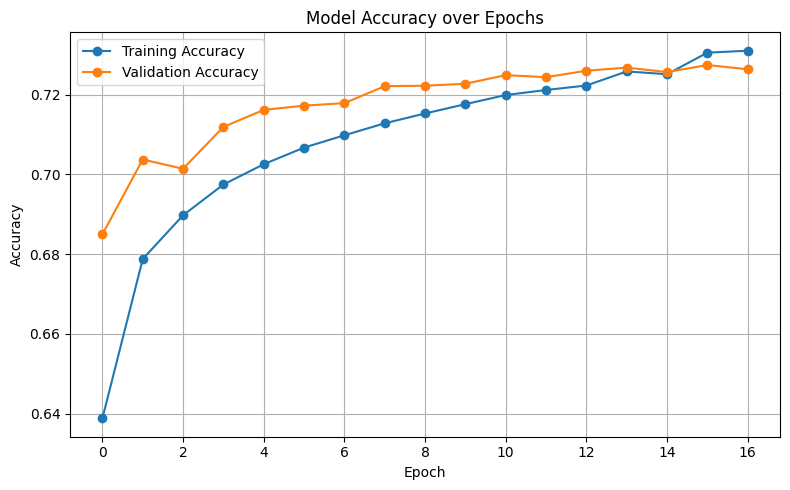

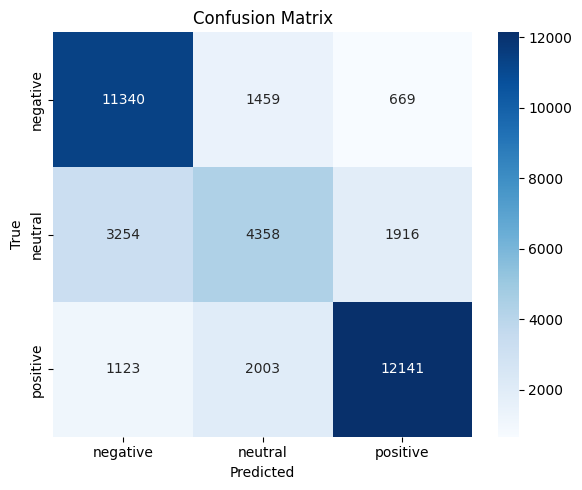

In [ ]:
# Build model
lstm_model = Sequential([
    Input(shape=(max_len,)),
    Embedding(
        input_dim=vocab_size,
        output_dim=w2v_dim,
        weights=[embedding_matrix],
        trainable=False
    ),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5)
]

# Train
lstm_history = lstm_model.fit(
    X_train_seq_lstm, y_train_cat_lstm,
    validation_data=(X_val_seq_lstm, y_val_cat_lstm),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    shuffle=True,
    verbose=2
)

# Evaluate
loss, acc = lstm_model.evaluate(X_test_seq_lstm, y_test_cat_lstm, verbose=0)
print(f"Test Loss: {loss:.4f} | Test Accuracy: {acc:.4f}")

# Classification report
y_pred_probs_lstm = lstm_model.predict(X_test_seq_lstm)
y_pred_classes_lstm = np.argmax(y_pred_probs_lstm, axis=1)
y_true_classes_lstm = np.argmax(y_test_cat_lstm, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes_lstm, y_pred_classes_lstm, target_names=['-1', '0', '1'], digits = 3))


# Plot training & validation accuracy values
plt.figure(figsize=(8, 5))
plt.plot(lstm_history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Generate confusion matrix
cm = confusion_matrix(y_true_classes_lstm, y_pred_classes_lstm)

# Class labels (matching your label mapping: {-1: 0, 0: 1, 1: 2})
labels = ['negative', 'neutral', 'positive']

# Plot using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()



Other considered models

# LR

Main model

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

    negative      0.768     0.749     0.758     13468
     neutral      0.503     0.590     0.543      9528
    positive      0.831     0.759     0.793     15267

    accuracy                          0.714     38263
   macro avg      0.701     0.699     0.698     38263
weighted avg      0.727     0.714     0.719     38263



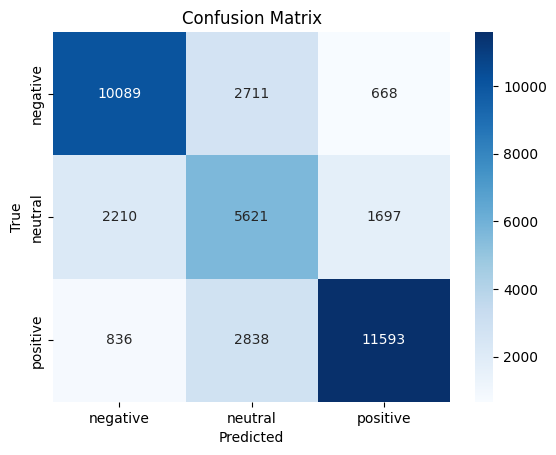


Prediction Probabilities (sample):
   true_label  negative   neutral  positive
0           0  0.701697  0.085071  0.213231
1           0  0.750030  0.216909  0.033061
2           2  0.026702  0.023305  0.949993
3           2  0.068022  0.291695  0.640283
4           2  0.151418  0.560598  0.287984


In [ ]:
# --- Train Logistic Regression ---
lr_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced'
)
lr_model.fit(X_train_val_tfidf, y_train_lr)

# --- Predict ---
y_pred_tfidf = lr_model.predict(X_test_tfidf)
y_proba = lr_model.predict_proba(X_test_tfidf)

# --- Evaluation ---
print("\nClassification Report:")
print(classification_report(y_test_lr, y_pred_tfidf, target_names=["negative", "neutral", "positive"], digits=3))

cm = confusion_matrix(y_test_lr, y_pred_tfidf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# --- Optional: Prediction probabilities dataframe ---
proba_df = pd.DataFrame(y_proba, columns=["negative", "neutral", "positive"])
result_df = pd.DataFrame({'true_label': y_test_lr.reset_index(drop=True)})
result_df = pd.concat([result_df, proba_df], axis=1)

print("\nPrediction Probabilities (sample):")
print(result_df.head())

Other considered models

In [ ]:
#Code used for tuning tfidf parameters:
"""
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

def cross_val_score_max_features(data, feature_range, k_folds=5):
    y = data['label'].values
    texts = data['lemmatized_text'].values
    scores = []

    best_score = -np.inf
    best_k = None

    for max_f in feature_range:
        vectorizer = TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=max_f,
            min_df=5,
            max_df=0.8,
            norm='l2'
        )
        X = vectorizer.fit_transform(texts)
        skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

        fold_scores = []
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            model = LogisticRegression(
                multi_class='multinomial',
                solver='lbfgs',
                max_iter=1000,
                class_weight='balanced'
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = f1_score(y_test, y_pred, average='weighted')
            fold_scores.append(score)

        avg_score = np.mean(fold_scores)
        scores.append((max_f, avg_score))
        print(f"max_features={max_f}, average F1-weighted={avg_score:.4f}")

        if avg_score > best_score:
            best_score = avg_score
            best_k = max_f

    print(f"\nBest max_features: {best_k} with F1-weighted={best_score:.4f}")
    return best_k, scores
"""